In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('./input/triple.csv')
#print(df)

In [3]:
df.info()
# df is a [719719 rows x 3 columns] DataFrame
# columns are organized as [subject, property, object]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719719 entries, 0 to 719718
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   subject   719719 non-null  object
 1   property  719719 non-null  object
 2   object    719719 non-null  object
dtypes: object(3)
memory usage: 16.5+ MB


In [4]:
# extraction of each row's property and subject 
# drop the duplicates
propertysubject = df.loc[:, ['property', 'subject']].drop_duplicates().values

# extraction of each row's property and object 
# drop the duplicates
propertyobject = df.loc[:, ['property', 'object']].drop_duplicates().values

In [5]:
def setGenerater(property_entity):
  sets = {}

  for i in property_entity:
    key = i[0]
    if key not in sets:
        sets[key] = []
        sets[key].append(i[1])
    else:
        sets[key].append(i[1])
  
  return sets 

In [6]:
def jaccard(x, y):
    xset = set(x)
    yset = set(y)
    intersection = len(xset & yset)
    union = len(xset | yset)
    
    try:
        return float(intersection/union)
    except ZeroDivisionError:
        return 0.0

In [7]:
def jaccardMatrixGenerater(sets):
  sets_values = np.array(list(sets.values()), dtype=object)

  jaccardMatrix = np.zeros((len(sets_values), len(sets_values)))
  for i in range(len(sets_values)):
    for j in range(len(sets_values)):
      jaccardMatrix[i][j] = jaccard(sets_values[i],sets_values[j])

  return jaccardMatrix

In [8]:
def jaccardAverageMatrix(propertysubject, propertyobject):
  ps_sets = setGenerater(propertysubject)
  po_sets = setGenerater(propertyobject)
  if ps_sets.keys() == po_sets.keys():
    ps_jaccard_matrix = jaccardMatrixGenerater(ps_sets)
    po_jaccard_matrix = jaccardMatrixGenerater(po_sets)
    avg_matrix = (ps_jaccard_matrix + po_jaccard_matrix)/2
    return avg_matrix
  else:
    raise Exception('PredicateOrderIsNotTheSame!')

## Main processing

In [9]:
import collections
from scipy import spatial, cluster
from matplotlib import pyplot as plt

average_jaccard_matrix = 1 - jaccardAverageMatrix(propertysubject, propertyobject)

# Average Jaccard matrix convert into a square distance matrix
jdist = spatial.distance.squareform(average_jaccard_matrix) 
# AHC performed on the Jaccard distance matrix
J = cluster.hierarchy.linkage(jdist, method="average") 

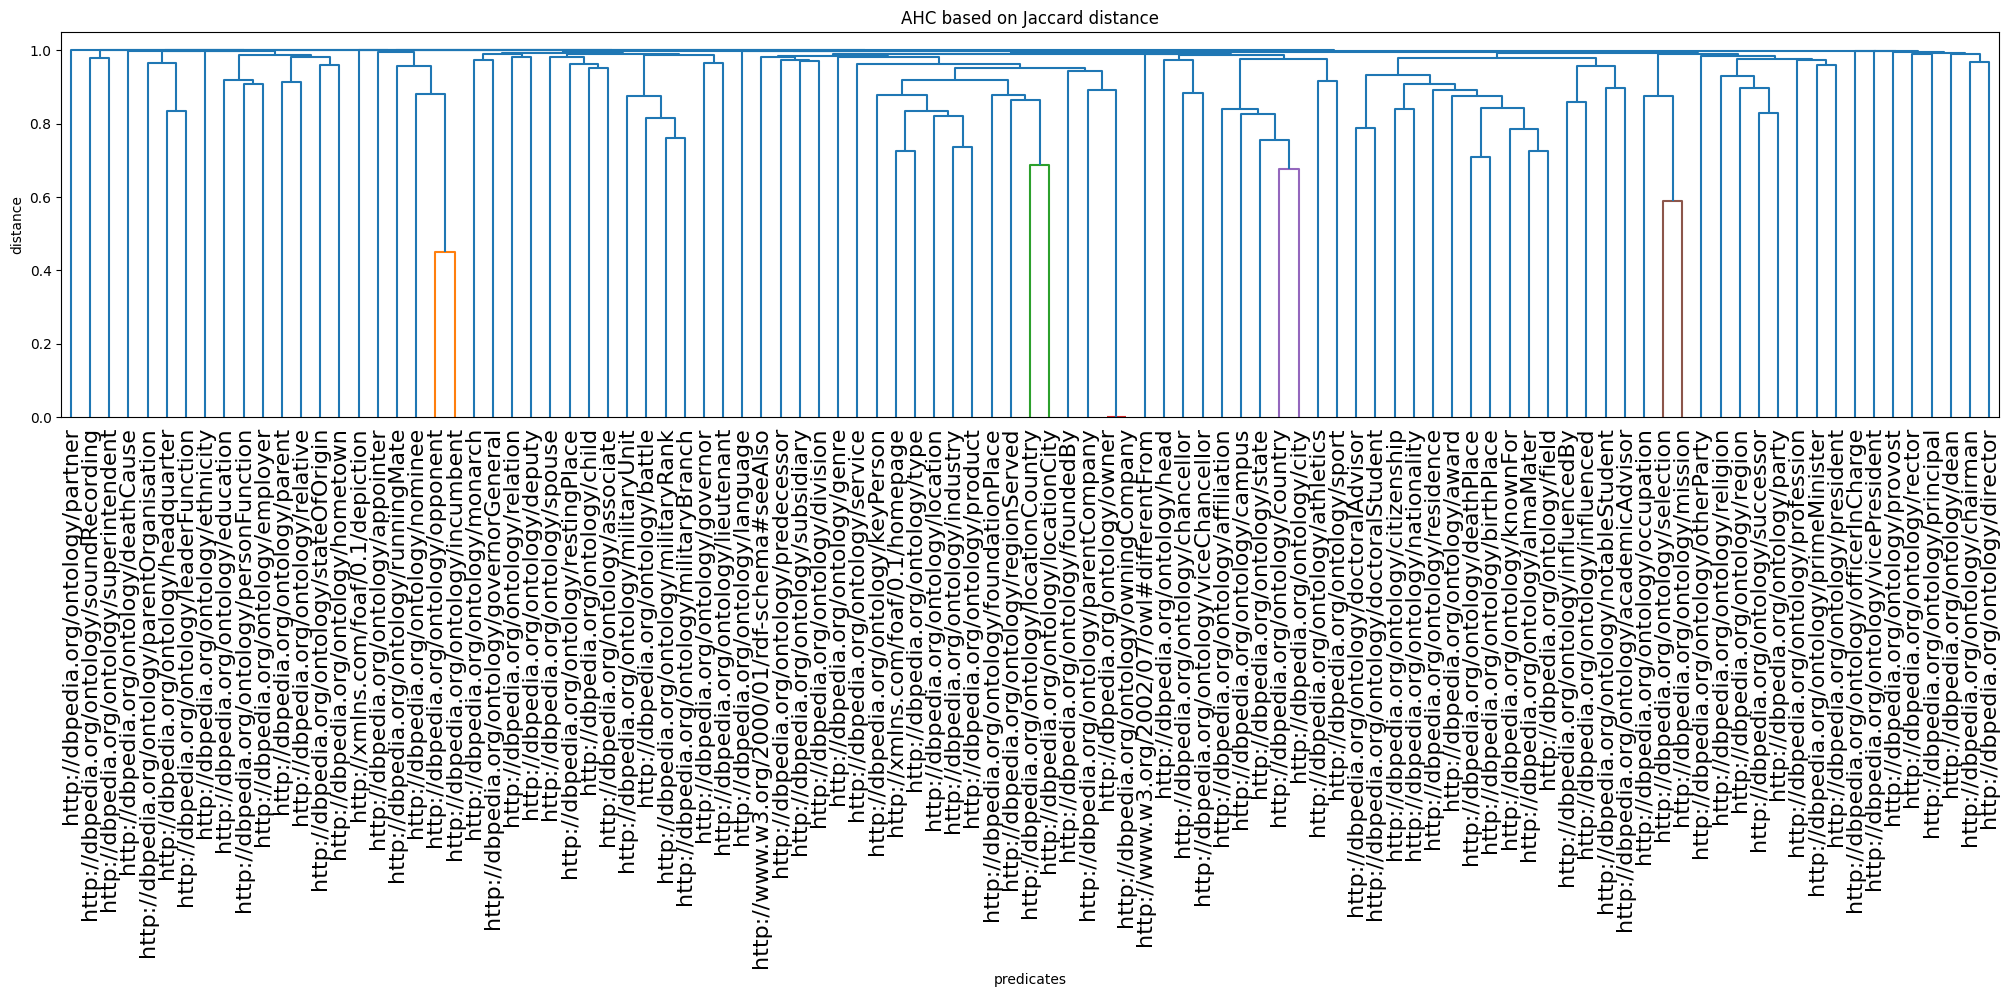

In [10]:
# Generate the dendrogramm based on the Jaccard distance
# for the AHC on predicates
fig = plt.figure(figsize=(25, 5))
plt.title("AHC based on Jaccard distance")
plt.xlabel("predicates")
plt.ylabel("distance")
dn = cluster.hierarchy.dendrogram(J, labels=list(setGenerater(propertysubject).keys()), leaf_font_size=16)
plt.show()

In [11]:
result = cluster.hierarchy.fcluster(J, t=0.990, criterion="distance")
# Check the number of clusters generated
print(len(collections.Counter(result)))
#Check the number of elements per cluster
print(collections.Counter(result).most_common())

23
[(11, 20), (13, 15), (14, 11), (12, 11), (3, 7), (10, 6), (9, 4), (8, 4), (6, 4), (2, 3), (1, 2), (17, 2), (16, 2), (22, 1), (15, 1), (5, 1), (7, 1), (20, 1), (23, 1), (4, 1), (19, 1), (18, 1), (21, 1)]


In [12]:
result

array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 14, 11, 11, 11, 11, 11,
       22, 12, 11, 12, 11, 11, 11, 15,  2,  2, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13,  9, 13, 13, 13,  5,  1, 14,  3,  3,  9,  3,  3,
        3,  9,  8, 14, 14, 14, 14,  9, 10,  8, 14,  8, 10,  7, 20, 14, 14,
       10, 10, 10, 14,  8, 14, 23, 10, 12,  6,  6,  3,  3,  4,  6,  6, 12,
       12, 12, 12, 17, 12, 19, 16, 12, 12, 16, 12,  1, 17, 18, 21,  2],
      dtype=int32)

In [13]:
# Output results
clusterResult={}
proplist = list(setGenerater(propertysubject).keys())

for i, prop in enumerate(proplist):
    clusterResult[prop] = result[i]

df_cluster= pd.DataFrame(clusterResult.keys(), index=clusterResult.values())
print(df_cluster.index)

Int64Index([11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
            ...
            16, 12, 12, 16, 12,  1, 17, 18, 21,  2],
           dtype='int64', length=101)
